In [52]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs
from utils_plotting import recall_plots
import pickle

In [53]:
np.random.seed(0)

# Initialize RNN

In [54]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [55]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    narrow_search_factor=0.5, wide_search_factor=1.5,
    )
original_J_xx = model.J_xx.copy()

In [56]:
cache_states = [20, 35, 70]

# Add predictive skew to RNN weights

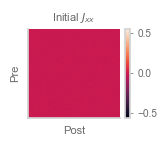

In [57]:
plt.figure(figsize=(1.75, 1.5))
original_J_xx = model.J_xx.copy()
plt.imshow(original_J_xx, aspect='auto')
plt.colorbar()
plt.title(r'Initial $J_{xx}$')
plt.xlabel('Post')
plt.ylabel('Pre')
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [58]:
with open('pickles/fig6_pred_matrix.p', 'rb') as f:
        total_delta = pickle.load(f)
        
model.reset()
w1 = 1.25
w2 = 1.5
model.J_xx = (w1)*original_J_xx.copy() + (w2)*total_delta

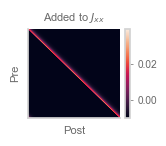

In [59]:
plt.figure(figsize=(1.75, 1.5))
plt.imshow(total_delta, aspect='auto')
plt.colorbar()
plt.title(r'Added to $J_{xx}$')
plt.xlabel('Post')
plt.ylabel('Pre')
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.savefig('figures/figS6_a.svg', dpi=300, transparent=True)
plt.show()

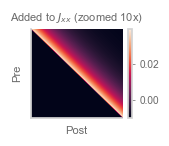

In [60]:
plt.figure(figsize=(1.75, 1.5))
plt.imshow(total_delta[:int(N_bar*0.1), :int(N_bar*0.1)], aspect='auto')
plt.colorbar()
plt.title(r'Added to $J_{xx}$ (zoomed 10x)')
plt.xlabel('Post')
plt.ylabel('Pre')
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.savefig('figures/figS6_b.svg', dpi=300, transparent=True)
plt.show()

# RNN activity under different recurrent strengths
(Black line indicates the identity line)

#### $r=0$

In [61]:
_, acts0, _, _ = model.run_recurrent(place_inputs, rec_strength=0., seed_steps=0)

#### $r=0.3$

In [62]:
_, acts03, _, _ = model.run_recurrent(place_inputs, rec_strength=0.3, seed_steps=0)

#### $r=1.0$

In [63]:
_, acts1, _, _ = model.run_recurrent(place_inputs, rec_strength=1.0, seed_steps=0)

# Subsampled

0.8647341035889826


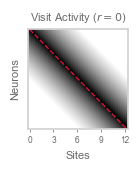

In [64]:
p = 0.4
plt.figure(figsize=(1.75, 1.75))
subsample = acts0[:int(num_states*p), :int(N_bar*p)].T
plt.imshow(
    subsample,
    aspect=subsample.shape[1]/subsample.shape[0],
    cmap='binary',
    vmin=0)
plt.plot([0,int(num_states*p)-1], [0,int(N_bar*p)-1], color='crimson', linestyle='--')
plt.ylabel('Neurons')
plt.yticks([])
plt.xlabel('Sites')
plt.xticks([0, 24*p, 48*p, 72*p, 96*p], [0, 3, 6, 9, 12], fontsize=6)
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
#plt.yticks([0, 24*p, 48*p, 72*p], [0, 3, 6, 9])
plt.title(f"Visit Activity ($r=0$)")
plt.tight_layout()
plt.savefig('figures/fig6b.svg', dpi=300, transparent=True)
print(acts0.max())
plt.show()

2.648730876738726


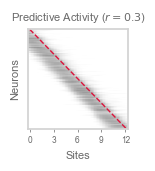

In [65]:
p = 0.35
plt.figure(figsize=(1.75, 1.75))
subsample = acts03[:int(num_states*p), :int(N_bar*p)].T
plt.imshow(
    subsample,
    aspect=subsample.shape[1]/subsample.shape[0],
    cmap='binary',
    vmin=0)
plt.plot([0,int(num_states*p)-1], [0,int(N_bar*p)-1], color='crimson', linestyle='--')
plt.ylabel('Neurons')
plt.yticks([])
plt.xlabel('Sites')
plt.xticks([0, 24*p, 48*p, 72*p, 96*p], [0, 3, 6, 9, 12], fontsize=6)
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.title(f"Predictive Activity ($r=0.3$)")
plt.tight_layout()
plt.savefig('figures/fig6c.svg', dpi=300, transparent=True)
print(acts03.max())
plt.show()

4.0867224598967375


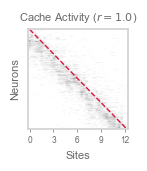

In [76]:
p = 0.4
ptile = 99.7
plt.figure(figsize=(1.75, 1.75))
subsample = acts1[:int(num_states*p), :int(N_bar*p)].T
plt.imshow(
    subsample,
    aspect=subsample.shape[1]/subsample.shape[0],
    cmap='binary',
    vmin=0, vmax=np.percentile(subsample, ptile))
plt.plot([0,int(num_states*p)-1], [0,int(N_bar*p)-1], color='crimson', linestyle='--')
plt.ylabel('Neurons')
plt.yticks([])
plt.xlabel('Sites')
plt.xticks([0, 24*p, 48*p, 72*p, 96*p], [0, 3, 6, 9, 12], fontsize=6)
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.title(f"Cache Activity ($r=1.0$)")
plt.tight_layout()
plt.savefig('figures/fig6d.svg', dpi=300, transparent=True)
print(np.percentile(subsample, ptile))
plt.show()


# Running learning +  narrow/broad Recall

In [18]:
identification_s = 0.0

Now I just cached at location: 20


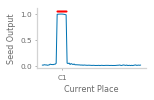

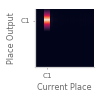

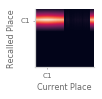

Now I just cached at location: 35


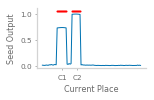

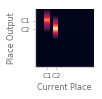

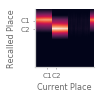

Now I just cached at location: 70


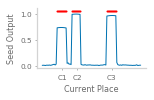

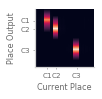

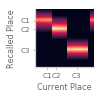

In [19]:
cache_identification = []
narrow_recall = []
wide_recall = []
model.reset()

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, outputs, _ = model.run_recall(identification_s, place_inputs)
    _cache_identification = outputs[1].squeeze()
    cache_identification.append(_cache_identification.copy())
    
    _, _, outputs, _ = model.run_recall(identification_s, place_inputs)
    _narrow_recall = relu(outputs[0])
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, outputs, _ = model.run_wide_recall(place_inputs)
    _wide_recall = relu(outputs[0])
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall, _wide_recall, cache_states[:c_idx+1])